In [3]:
%load_ext autoreload
%autoreload 2
import fsspec
import numpy as np
import pandas as pd
import xarray as xr
from carbonplan.data import cat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib
from carbonplan_data import utils
from matplotlib import cm
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import rioxarray

from carbonplan_trace.v1 import utils as trace_utils
from carbonplan_trace.v1 import glas_allometric_eq as allo

import os
from carbonplan_trace.v0.data import cat as trace_cat

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 14, "svg.fonttype": "none"})

from gcsfs import GCSFileSystem
fs = GCSFileSystem(cache_timeout=0)

import seaborn as sns
sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import dask
# from dask.distributed import Client

# client = Client(n_workers=4, threads_per_worker=3)
# client

# Open data

- from this study
- from Lidar validation data sets (Margolis et al 2015 and Neigh et al 2015)
- Spawn et al 2020 (for year 2010)
- Hansen et al 2007 (for year 2000)

To do:

- Jon Wang
- FIA


In [12]:
def open_biomass_data(tiles=None, min_lat=-90, max_lat=90, min_lon=-180, max_lon=180):
    folder = "s3://carbonplan-climatetrace/v1/data/intermediates/biomass/"
    if not tiles:
        s3fs = fsspec.get_filesystem_class("s3")()
        tiles = [
            os.path.splitext(os.path.split(path)[-1])[0]
            for path in s3fs.ls(folder)
            if not path.endswith("/")
        ]
    uris = [f"{folder}{tile}.zarr" for tile in tiles]
    ds_list = []
    for uri in uris:
        try:
            mapper = fsspec.get_mapper(uri)
            ds = xr.open_zarr(mapper, consolidated=True)
            ds = ds.stack(unique_index=("record_index", "shot_number")).dropna(
                dim="unique_index", how="any", subset=["lat", "lon", "biomass"]
            )
            ds = ds.drop_vars("spatial_ref")
            ds.attrs["crs"] = "EPSG:4326"
            ds = trace_utils.subset_data_for_bounding_box(ds, min_lat, max_lat, min_lon, max_lon)
            ds_list.append(
                ds[
                    [
                        "biomass",
                        "lat",
                        "lon",
                        "allometric_eq",
                        "ecoregion",
                        "igbp",
                    ]
                ].where(ds.igbp.isin([1, 2, 3, 4, 5, 8, 9]), drop=True)
            )
        except KeyError:
            print(f"did not find {uri}")
        except ZeroDivisionError:
            print(f"{uri} do not have any data")

    ds = xr.concat(ds_list, dim="unique_index", data_vars="minimal").chunk({"unique_index": 2000})
    for k in ds:
        _ = ds[k].encoding.pop("chunks", None)

    return ds


def turn_point_cloud_to_grid(ds, format_grid):
    gridded_df = format_grid.sel(lat=ds.lat, lon=ds.lon, method="nearest")
    gridded_df["biomass"] = ds["biomass"]
    gridded_df = (
        gridded_df.to_dataframe()
        .reset_index(drop=True)
        .groupby(["lat", "lon"])
        .biomass.mean()
        .reset_index()
        .dropna()
    )
    pivot = gridded_df.pivot(columns="lon", index="lat", values="biomass").reindex(
        index=format_grid.lat.values, columns=format_grid.lon.values
    )
    ds_grid = xr.DataArray(
        data=pivot.values,
        dims=["lat", "lon"],
        coords=[format_grid.coords["lat"], format_grid.coords["lon"]],
    )
    ds_grid = ds_grid.to_dataset(name="biomass", promote_attrs=True)

    return ds_grid


def open_spawn_data(
    min_lat=-90,
    max_lat=90,
    min_lon=-180,
    max_lon=180,
    coarsen=10,
    to_coarsen=False,
    preprocessed=True,
):
    # for year 2010
    # https://daac.ornl.gov/VEGETATION/guides/Global_Maps_C_Density_2010.html
    # in a different crs, units Mg C/ha

    if preprocessed:
        spawn = trace_utils.open_zarr_file(
            "s3://carbonplan-climatetrace/intermediate/spawn_biomass_3km.zarr"
        )
        spawn = spawn.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon, max_lon))

    else:
        spawn = xr.open_rasterio(
            "gs://carbonplan-data/raw/2010-harmonized-biomass/global/300m/aboveground.tif"
        ).chunk({"x": 5120, "y": 5120})

        spawn = 0.2 * (spawn.rename({"x": "lon", "y": "lat"}).squeeze(drop=True))
        spawn = spawn.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon, max_lon))
        if to_coarsen:
            spawn = spawn.coarsen(lat=coarsen, lon=coarsen, boundary="trim").mean().compute()
        spawn = spawn.to_dataset(name="biomass", promote_attrs=True)

    return spawn


def open_hansen_data(
    tiles=None,
    min_lat=-90,
    max_lat=90,
    min_lon=-180,
    max_lon=180,
    coarsen=100,
    to_coarsen=False,
    preprocessed=True,
):
    # https://data.globalforestwatch.org/datasets/8f93a6f94a414f9588ce4657a39c59ff_1?geometry=-146.250%2C-66.901%2C146.250%2C82.366
    # units in Mg biomass/ha

    if preprocessed:
        hansen = trace_utils.open_zarr_file(
            "s3://carbonplan-climatetrace/intermediate/hansen_biomass_3km.zarr"
        )
        hansen = hansen.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

    else:
        hansen = []
        failed = []
        for tile in tiles:
            try:
                lat, lon = trace_utils.get_lat_lon_tags_from_tile_path(tile)
                # get Hansen data
                hansen_tile = trace_cat.gfw_biomass(lat=lat, lon=lon).to_dask()
                hansen_tile = hansen_tile.rename({"x": "lon", "y": "lat"}).squeeze(drop=True)
                if to_coarsen:
                    hansen_tile = (
                        hansen_tile.coarsen(lat=coarsen, lon=coarsen, boundary="trim")
                        .mean()
                        .compute()
                    )
                hansen.append(hansen_tile.to_dataset(name="biomass", promote_attrs=True))
            except:
                print(tile + "failed")
                failed.append(tile)

        failed = []
        for tile in failed:
            lat, lon = trace_utils.get_lat_lon_tags_from_tile_path(tile)
            # get Hansen data
            hansen_tile = trace_cat.hansen_biomass(lat=lat, lon=lon).to_dask()
            hansen_tile = hansen_tile.rename({"x": "lon", "y": "lat"}).squeeze(drop=True)
            if to_coarsen:
                hansen_tile = (
                    hansen_tile.coarsen(lat=coarsen, lon=coarsen, boundary="trim").mean().compute()
                )
            hansen.append(hansen_tile.to_dataset(name="biomass", promote_attrs=True))

        hansen = xr.combine_by_coords(hansen, combine_attrs="drop_conflicts").chunk(
            {"lat": 5120, "lon": 5120}
        )

    return hansen

In [13]:
import pandas as pd

rename_dict = {
    "Glas record index": "record_index",
    "rec_ndx": "record_index",
    "Shotn": "shot_number",
    "shotn": "shot_number",
    "lngtd": "lon",
    "h14": "VH",
    "fslope": "f_slope",
    "Senergy": "senergy",
    "h25": "h25_Neigh",
    "h50": "h50_Neigh",
    "h75": "h75_Neigh",
    "h90": "h90_Neigh",
    "glas_biom_str": "biomass",
}


def convert_df_to_xr(df):
    df["unique_index"] = (
        df.record_index.astype(str).str.zfill(9) + "_" + df.shot_number.astype(str).str.zfill(2)
    )
    df.set_index(["record_index", "shot_number"], inplace=True)

    ds = {}
    for c in df.columns:
        ds[c] = xr.DataArray(
            df[c].values,
            dims=["unique_index"],
            coords={"unique_index": df.unique_index.values},
        )
    ds = xr.Dataset(ds)
    ds.coords["unique_index"] = df.index
    return ds


def open_margolis_data(min_lat=-90, max_lat=90, min_lon=-180, max_lon=180):
    files = [
        "gs://carbonplan-climatetrace/inputs/boreal_lidar_biomass/Alaska_BBB3_hg_L3c_L3f_wPALSbiom.txt",
        "gs://carbonplan-climatetrace/inputs/boreal_lidar_biomass/Canada_east_BBB3_hg_L3c_L3f_wPALSbiom.txt",
        "gs://carbonplan-climatetrace/inputs/boreal_lidar_biomass/Canada_west_BBB3_hg_L3c_L3f_wPALSbiom.txt",
    ]

    margolis = []
    for file in files:
        with fs.open(file) as f:
            data = np.genfromtxt(f, skip_header=8)
        with fs.open(file) as f:
            lines = f.readlines()
        headers = lines[7]
        headers = [c for c in headers.decode("utf-8").strip().split(" ") if c != ""]
        margolis.append(pd.DataFrame(data=data, columns=headers))
    margolis = pd.concat(margolis)
    for c in margolis:
        if c in rename_dict:
            margolis.rename(columns={c: rename_dict[c]}, inplace=True)

    margolis = margolis.replace(-9999, np.nan).replace(99999, np.nan)
    margolis = convert_df_to_xr(margolis)
    margolis = trace_utils.subset_data_for_bounding_box(
        margolis, min_lat, max_lat, min_lon, max_lon
    )

    return margolis

In [14]:
min_lat = -90
max_lat = 90
min_lon = -180
max_lon = 180

tiles = trace_utils.find_tiles_for_bounding_box(
    min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon
)
print("loading hansen")
hansen = open_hansen_data(
    preprocessed=True,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
)
print("loading spawn")
spawn = open_spawn_data(
    preprocessed=True,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
)
print("loading this study")
study = open_biomass_data(
    tiles=None,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
)
print("gridding study")
gridded_study_hansen = turn_point_cloud_to_grid(ds=study, format_grid=hansen)
gridded_study_spawn = turn_point_cloud_to_grid(ds=study, format_grid=spawn)
# print('loading margolis')
# margolis = open_margolis_data(min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)

loading hansen
loading spawn
loading this study
gridding study


In [15]:
study

<xarray.Dataset>
Dimensions:        (unique_index: 12198165)
Coordinates:
    band           int64 1
  * unique_index   (unique_index) MultiIndex
  - record_index   (unique_index) int64 32220370 32220370 ... 763526159
  - shot_number    (unique_index) int64 18 24 33 34 18 34 40 ... 8 31 22 3 4 23
Data variables:
    biomass        (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    lat            (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    lon            (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    allometric_eq  (unique_index) object dask.array<chunksize=(2000,), meta=np.ndarray>
    ecoregion      (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    igbp           (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

In [16]:
study.nbytes / 1e9

0.683097248

In [17]:
gridded_study_hansen

<xarray.Dataset>
Dimensions:  (lat: 5600, lon: 14400)
Coordinates:
  * lat      (lat) float64 -59.99 -59.96 -59.94 -59.91 ... 79.94 79.96 79.99
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    biomass  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [18]:
gridded_study_spawn

<xarray.Dataset>
Dimensions:  (lat: 5220, lon: 12960)
Coordinates:
  * lat      (lat) float64 83.99 83.96 83.93 83.9 ... -60.9 -60.93 -60.96 -60.99
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    biomass  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [19]:
study["realm"] = allo.get_realm_from_ecoregion(study.ecoregion).load()

In [20]:
study

<xarray.Dataset>
Dimensions:        (unique_index: 12198165)
Coordinates:
    band           int64 1
  * unique_index   (unique_index) MultiIndex
  - record_index   (unique_index) int64 32220370 32220370 ... 763526159
  - shot_number    (unique_index) int64 18 24 33 34 18 34 40 ... 8 31 22 3 4 23
Data variables:
    biomass        (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    lat            (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    lon            (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    allometric_eq  (unique_index) object dask.array<chunksize=(2000,), meta=np.ndarray>
    ecoregion      (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    igbp           (unique_index) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    realm          (unique_index) <U10 'afrotropic' ... 'palearctic'
Attributes:
    crs:      EPSG:4326

# Compare biomass on scatter plots + error metrics


- index gridded study to gridded hansen and spawn, check for bias, MAE, r2, visual inspection


In [21]:
def index_point_cloud_to_reference(ds, format_grid, name):
    gridded_df = format_grid.sel(lat=ds.lat, lon=ds.lon, method="nearest")
    for v in ds:
        if v not in ["lat", "lon"]:
            gridded_df[v] = ds[v]
    grouped = gridded_df.to_dataframe().reset_index(drop=True).dropna().groupby(["lat", "lon"])

    mode = lambda x: x.value_counts().index[0]

    grouped = grouped.agg(
        biomass=pd.NamedAgg(column="biomass", aggfunc="mean"),
        n_shots_in_grid=pd.NamedAgg(column="biomass", aggfunc="count"),
        allometric_eq=pd.NamedAgg(column="allometric_eq", aggfunc=mode),
        #         ecoregion=pd.NamedAgg(column="ecoregion", aggfunc=mode),
        #         igbp=pd.NamedAgg(column="igbp", aggfunc=mode),
        realm=pd.NamedAgg(column="realm", aggfunc=mode),
    )

    gridded_df_xr = xr.Dataset.from_dataframe(grouped.reset_index())
    format_grid_records = trace_utils.find_matching_records(
        data=format_grid, lats=gridded_df_xr.lat, lons=gridded_df_xr.lon
    )
    grouped[f"{name}_biomass"] = format_grid_records.biomass.values

    return grouped

In [22]:
print("hansen")
fn = "gridded_study_df_hansen_forests_only.csv"
if os.path.exists(fn):
    gridded_study_df_hansen = pd.read_csv(fn)
else:
    gridded_study_df_hansen = index_point_cloud_to_reference(study, hansen, "hansen")
    gridded_study_df_hansen.to_csv(fn)
    gridded_study_df_hansen = gridded_study_df_hansen.reset_index()

print("spawn")
fn = "gridded_study_df_spawn_forests_only.csv"
if os.path.exists(fn):
    gridded_study_df_spawn = pd.read_csv(fn)
else:
    gridded_study_df_spawn = index_point_cloud_to_reference(study, spawn, "spawn")
    gridded_study_df_spawn.to_csv(fn)
    gridded_study_df_spawn = gridded_study_df_spawn.reset_index()

hansen
spawn


## R squared, bias, and MAE compared to Hansen and Spawn datasets

- overall score
- score by Realm


In [23]:
for name, df in zip(["Hansen", "Spawn"], [gridded_study_df_hansen, gridded_study_df_spawn]):
    for count_threshold in [0, 10, 20]:
        col_name = f"{name.lower()}_biomass"
        sub = df.loc[df.n_shots_in_grid >= count_threshold, [col_name, "biomass"]].dropna()
        ytrue = sub[col_name].values
        ypred = sub.biomass.values
        bias = np.mean(ypred - ytrue)
        r2 = r2_score(ytrue, ypred)
        mae = mean_absolute_error(ytrue, ypred)
        print(
            f"Comparing to {name.ljust(6, ' ')} dataset with threshold {count_threshold}, number of records = {len(ytrue)}, R2 = {str(round(r2, 2)).ljust(5, ' ')}, bias = {round(bias, 1)} Mg/ha, MAE = {round(mae, 1)} Mg/ha"
        )

    print()

Comparing to Hansen dataset with threshold 0, number of records = 3092637, R2 = 0.68 , bias = 8.1 Mg/ha, MAE = 22.7 Mg/ha
Comparing to Hansen dataset with threshold 10, number of records = 1438711, R2 = 0.8  , bias = 8.5 Mg/ha, MAE = 21.1 Mg/ha
Comparing to Hansen dataset with threshold 20, number of records = 773688, R2 = 0.83 , bias = 9.0 Mg/ha, MAE = 20.4 Mg/ha

Comparing to Spawn  dataset with threshold 0, number of records = 2754188, R2 = 0.15 , bias = 15.1 Mg/ha, MAE = 29.9 Mg/ha
Comparing to Spawn  dataset with threshold 10, number of records = 1367261, R2 = 0.35 , bias = 17.4 Mg/ha, MAE = 30.5 Mg/ha
Comparing to Spawn  dataset with threshold 20, number of records = 773778, R2 = 0.39 , bias = 19.1 Mg/ha, MAE = 31.4 Mg/ha



In [24]:
# separate out the calculation by realm
count_threshold = 10
for name, df in zip(["Hansen", "Spawn"], [gridded_study_df_hansen, gridded_study_df_spawn]):
    col_name = f"{name.lower()}_biomass"
    for realm in df.realm.unique():
        sub = df.loc[
            (df.realm == realm) & (df.n_shots_in_grid >= count_threshold),
            [col_name, "biomass"],
        ].dropna()
        ytrue = sub[col_name].values
        ypred = sub.biomass.values
        bias = np.mean(ypred - ytrue)
        r2 = r2_score(ytrue, ypred)
        mae = mean_absolute_error(ytrue, ypred)
        print(
            f"Comparing to {name.ljust(6, ' ')} dataset for realm {realm.ljust(13, ' ')} with threshold {count_threshold}, number of records = {str(len(ytrue)).ljust(6, ' ')}, R2 = {str(round(r2, 2)).ljust(5, ' ')}, bias = {round(bias, 1)} Mg/ha, MAE = {round(mae, 1)} Mg/ha"
        )

    print()

Comparing to Hansen dataset for realm neotropic     with threshold 10, number of records = 245313, R2 = 0.81 , bias = 10.8 Mg/ha, MAE = 35.4 Mg/ha
Comparing to Hansen dataset for realm australia     with threshold 10, number of records = 47105 , R2 = 0.82 , bias = -3.6 Mg/ha, MAE = 6.9 Mg/ha
Comparing to Hansen dataset for realm afrotropic    with threshold 10, number of records = 266372, R2 = 0.7  , bias = 21.0 Mg/ha, MAE = 29.5 Mg/ha
Comparing to Hansen dataset for realm tropical_a    with threshold 10, number of records = 101486, R2 = 0.79 , bias = 11.8 Mg/ha, MAE = 33.1 Mg/ha
Comparing to Hansen dataset for realm palearctic    with threshold 10, number of records = 545749, R2 = 0.68 , bias = 5.8 Mg/ha, MAE = 11.8 Mg/ha
Comparing to Hansen dataset for realm nearctic      with threshold 10, number of records = 232686, R2 = 0.54 , bias = -0.9 Mg/ha, MAE = 15.5 Mg/ha

Comparing to Spawn  dataset for realm neotropic     with threshold 10, number of records = 227400, R2 = 0.45 , bias = 3

In [25]:
# separate out the calculation by allometric eq
count_threshold = 10
for name, df in zip(["Hansen", "Spawn"], [gridded_study_df_hansen, gridded_study_df_spawn]):
    col_name = f"{name.lower()}_biomass"
    for realm in df.realm.unique():
        print(
            f"Comparing to {name.ljust(6, ' ')} dataset for realm {realm.ljust(13, ' ')} with threshold {count_threshold}"
        )
        sub = df.loc[(df.realm == realm) & (df.n_shots_in_grid >= count_threshold)]
        for eq in sub.allometric_eq.unique():
            subsub = sub.loc[sub.allometric_eq == eq]
            ytrue = subsub[col_name].values
            ypred = subsub["biomass"].values
            bias = np.mean(ypred - ytrue)
            r2 = r2_score(ytrue, ypred)
            mae = mean_absolute_error(ytrue, ypred)
            print(
                f"    For {eq.ljust(30, ' ')} equation, number of records = {str(len(ytrue)).ljust(6, ' ')}, R2 = {str(round(r2, 2)).ljust(5, ' ')}, bias = {round(bias, 1)} Mg/ha, MAE = {round(mae, 1)} Mg/ha"
            )

        print()

Comparing to Hansen dataset for realm neotropic     with threshold 10
    For extratropical_neotropic        equation, number of records = 13263 , R2 = 0.83 , bias = -4.3 Mg/ha, MAE = 7.6 Mg/ha
    For tropical_neotropic             equation, number of records = 232050, R2 = 0.8  , bias = 11.6 Mg/ha, MAE = 37.0 Mg/ha

Comparing to Hansen dataset for realm australia     with threshold 10
    For australia_beets_2011           equation, number of records = 2299  , R2 = 0.68 , bias = -14.3 Mg/ha, MAE = 22.2 Mg/ha
    For australia_lucas_2008           equation, number of records = 22642 , R2 = 0.83 , bias = -7.3 Mg/ha, MAE = 10.1 Mg/ha
    For australia_suganuma_2006        equation, number of records = 21701 , R2 = 0.93 , bias = 0.2 Mg/ha, MAE = 0.8 Mg/ha
    For australia_baccini_2012         equation, number of records = 463   , R2 = 0.07 , bias = 54.1 Mg/ha, MAE = 61.1 Mg/ha

Comparing to Hansen dataset for realm afrotropic    with threshold 10
    For afrotropic                     e

## Scatter plots compared to Hansen and Spawn datasets

- overall
- by Realm


In [26]:
def plot_scatter_comparison(
    ax,
    x_col,
    y_col,
    reference_name,
    comparison_name,
    plot_params,
    c="k",
    s=0.01,
    alpha=0.1,
):
    tot = np.hstack((x_col, y_col))
    xmax = np.percentile(tot, 99.5)
    xmin = plot_params["xmin"]
    unit = plot_params["unit"]

    ax.plot([xmin, xmax], [xmin, xmax], "r")
    r2 = r2_score(x_col, y_col)
    mae = mean_absolute_error(x_col, y_col)
    ax.scatter(x_col, y_col, c=c, s=s, alpha=alpha, marker="o")
    ax.text(plot_params["text_x"], xmax * 0.9, f"R squared = {round(r2, 2)}")
    ax.text(plot_params["text_x"], xmax * 0.81, f"MAE = {round(mae, 2)} {unit}")
    if unit != "":
        unit_str = f"({unit})"
    else:
        unit_str = ""
    ax.set_xlabel(f"Biomass from {reference_name} {unit_str}")
    ax.set_ylabel(f"Biomass from {comparison_name} {unit_str}")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ticks = np.arange(0, xmax, 100)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

In [27]:
plot_params = {
    "xmin": -10,
    "xmax": 510,
    "unit": "Mg/ha",
    "text_x": 10,
    "text_y1": 450,
    "text_y2": 420,
    "ticks": np.arange(0, 510, 100),
}

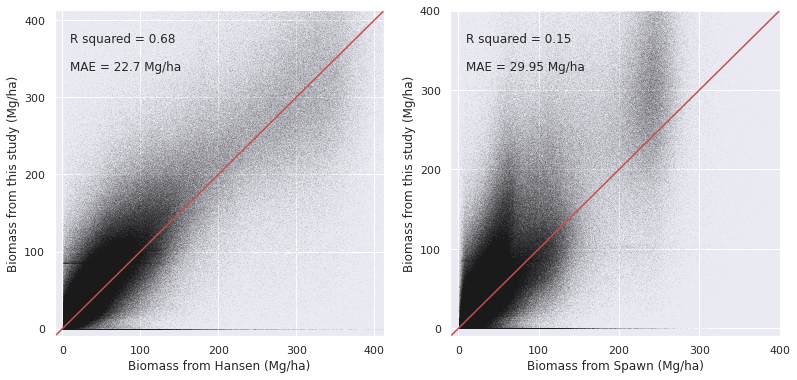

In [28]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
for i, (name, df) in enumerate(
    zip(["Hansen", "Spawn"], [gridded_study_df_hansen, gridded_study_df_spawn])
):
    col_name = f"{name.lower()}_biomass"
    sub = df[[col_name, "biomass"]].dropna()
    plot_scatter_comparison(
        ax=axarr[i],
        x_col=sub[col_name].values,
        y_col=sub.biomass.values,
        reference_name=name,
        comparison_name="this study",
        plot_params=plot_params,
    )

plt.show()
plt.close()

In [29]:
# seaborn plots

# for i, (name, df) in enumerate(zip(['Hansen', 'Spawn'], [gridded_study_df_hansen, gridded_study_df_spawn])):
#     col_name = f'{name.lower()}_biomass'
#     sns.jointplot(
#         ax=axarr[i],
#         data=df, x=col_name, y="biomass", hue="realm",
#         xlim=(plot_params['xmin'], plot_params['xmax']),
#         ylim=(plot_params['xmin'], plot_params['xmax']),
#         linewidth=0,
#         s=0.05,
#         alpha=0.5
#     )
#     plt.show()
#     plt.close()

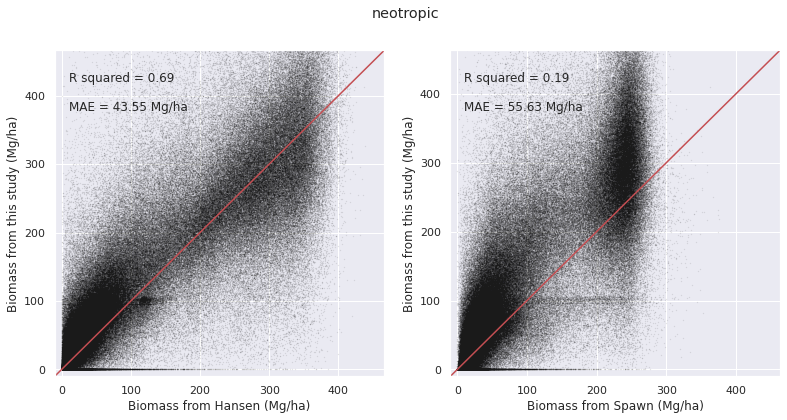

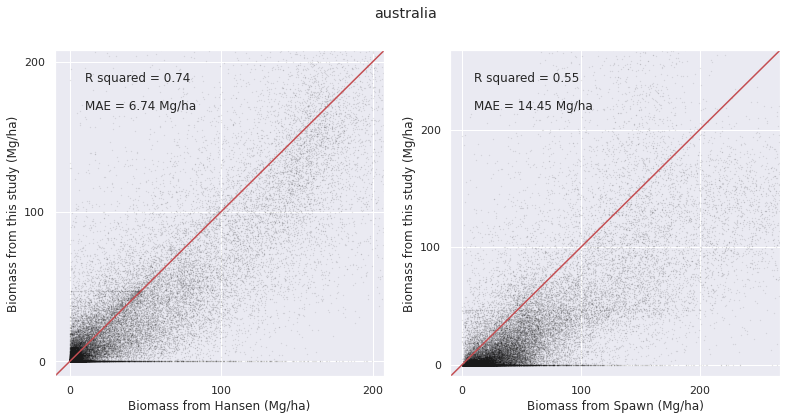

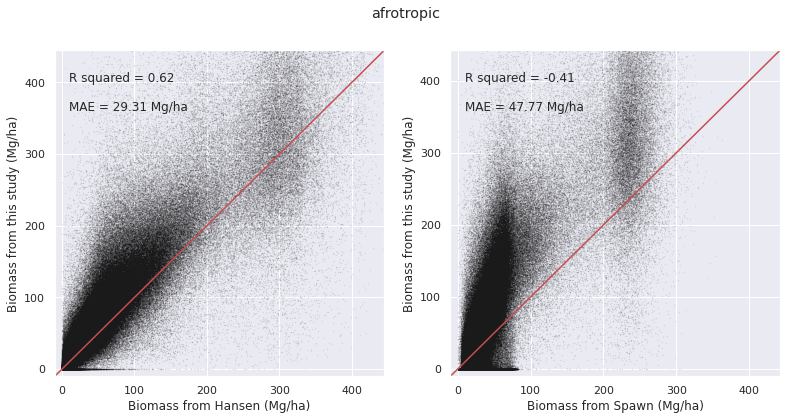

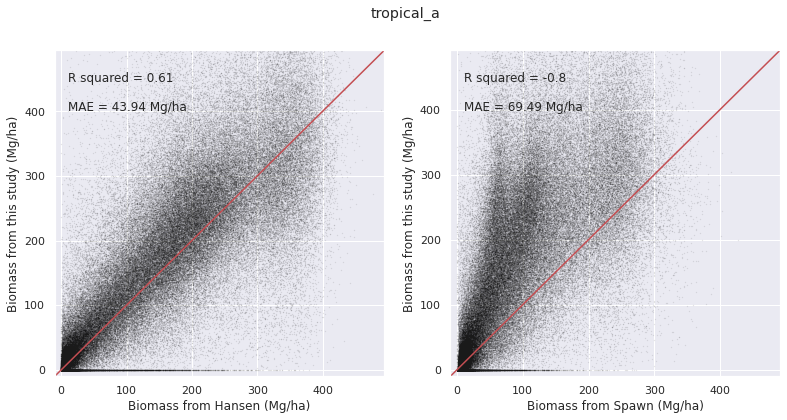

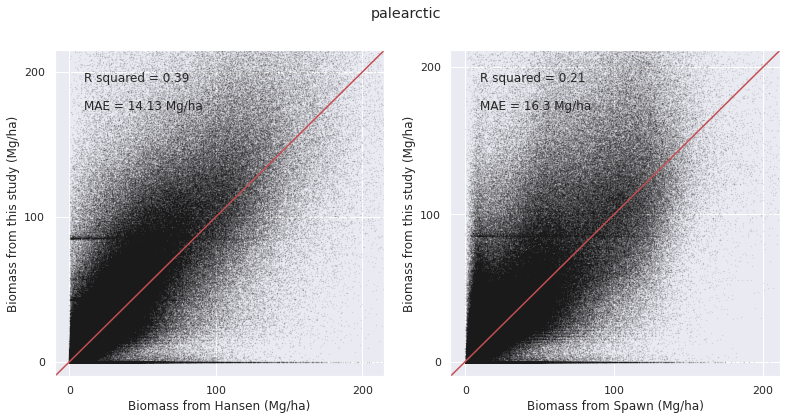

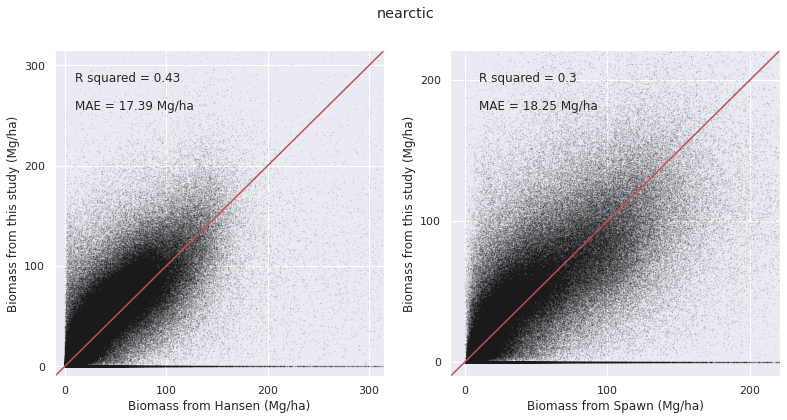

In [30]:
for realm in gridded_study_df_hansen.realm.unique():
    fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
    for i, (name, df) in enumerate(
        zip(
            ["Hansen", "Spawn"],
            [gridded_study_df_hansen, gridded_study_df_spawn],
        )
    ):
        col_name = f"{name.lower()}_biomass"
        plot_scatter_comparison(
            ax=axarr[i],
            x_col=df.loc[(df.realm == realm), col_name].values,
            y_col=df.loc[(df.realm == realm), "biomass"].values,
            reference_name=name,
            comparison_name="this study",
            plot_params=plot_params,
            s=0.05,
            alpha=0.2,
        )
    plt.suptitle(realm)
    plt.show()
    plt.close()

In [31]:
# seaborn plots

# for realm in gridded_study_df_hansen.realm.unique():
#     for i, (name, df) in enumerate(zip(['Hansen', 'Spawn'], [gridded_study_df_hansen, gridded_study_df_spawn])):
#         col_name = f'{name.lower()}_biomass'
#         sub = df.loc[(df.realm == realm)]
#         x_col = sub[col_name].values
#         y_col = sub['biomass'].values
#         tot = np.hstack((x_col, y_col))
#         xmax = np.percentile(tot, 99.5)
#         p = sns.jointplot(
#             data=sub, x=col_name, y="biomass", hue="allometric_eq",
#             xlim=(plot_params['xmin'], xmax),
#             ylim=(plot_params['xmin'], xmax),
#             linewidth=0,
#             s=0.2,
#             alpha=0.7
#         )
#         p.fig.suptitle(f'{realm} {name}')
#         plt.legend(bbox_to_anchor=(1.5, 0.5))
#         plt.show()
#         plt.close()

In [32]:
# plt.figure(figsize=(6,6))
# plot_scatter_comparison(
#     ax=plt.gca(),
#     x_col=gridded_study_df_with_counts.hansen_biomass.values,
#     y_col=gridded_study_df_with_counts.spawn_biomass.values,
#     reference_name='Hansen',
#     comparison_name='Spawn',
#     plot_params=plot_params
# )

# plt.show()
# plt.close()

## Error metrics for different IGBP classes


In [33]:
# # separate out the calculation by realm
# count_threshold = 10
# for name, df in zip(['Hansen', 'Spawn'], [gridded_study_df_hansen, gridded_study_df_spawn]):
#     col_name = f'{name.lower()}_biomass'
#     for realm in df.realm.unique():
#         sub = df.loc[(df.realm == realm) & (df.igbp.isin([1, 2, 3, 4, 5, 8, 9]))]
#         ytrue = sub.loc[sub.n_shots_in_grid >= count_threshold, col_name].values
#         ypred = sub.loc[sub.n_shots_in_grid >= count_threshold, 'biomass'].values
#         bias = np.mean(ypred - ytrue)
#         r2 = r2_score(ytrue, ypred)
#         mae = mean_absolute_error(ytrue, ypred)
#         print(f"Comparing to {name.ljust(6, ' ')} dataset for forests for realm {realm.ljust(13, ' ')} with threshold {count_threshold}, number of records = {str(len(ytrue)).ljust(6, ' ')}, R2 = {str(round(r2, 2)).ljust(5, ' ')}, bias = {round(bias, 1)} Mg/ha, MAE = {round(mae, 1)} Mg/ha")

#     print()

## index study to margolis, check for bias, MAE, r2


In [ ]:
study_df = study[["lat", "lon", "biomass"]].to_dataframe().reset_index()
margolis_df = (
    margolis[["lat", "lon", "biomass"]]
    .to_dataframe()
    .reset_index()
    .rename(columns={"biomass": "margolis_biomass"})
)

In [ ]:
precision = 4
study_df["lat_round"] = study_df.lat.round(precision)
study_df["lon_round"] = study_df.lon.round(precision)
margolis_df["lat_round"] = margolis_df.lat.round(precision)
margolis_df["lon_round"] = margolis_df.lon.round(precision)

merged = pd.merge(
    left=study_df,
    right=margolis_df,
    on=["lat_round", "lon_round"],
    suffixes=["_study", "_margolis"],
    how="inner",
)

In [ ]:
plt.figure(figsize=(6, 6))
plot_scatter_comparison(
    ax=plt.gca(),
    x_col=merged.margolis_biomass.values,
    y_col=merged.biomass.values,
    reference_name="Margolis",
    comparison_name="this study",
    plot_params=plot_params,
    s=0.1,
    alpha=1,
)

plt.show()
plt.close()

## Index on raw data from Hansen and Spawn


In [ ]:
# min_lat = -90
# max_lat = 90
# min_lon = -180
# max_lon = 180

# tiles = trace_utils.find_tiles_for_bounding_box(min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)
# raw_hansen = open_hansen_data(preprocessed=False, to_coarsen=False, tiles=tiles, min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)
# hansen_shots = trace_utils.find_matching_records(data=raw_hansen, lats=study.lat, lons=study.lon)
# study['hansen_biomass'] = hansen_shots['biomass']

# raw_spawn = open_spawn_data(preprocessed=False, to_coarsen=False, min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)
# spawn_shots = trace_utils.find_matching_records(data=raw_spawn, lats=study.lat, lons=study.lon)
# study['spawn_biomass'] = spawn_shots['biomass']

In [ ]:
# plt.figure(figsize=(6,6))
# ax = plt.gca()

# map_plot = study.plot.scatter(
#     x='hansen_biomass',
#     y='biomass',
#     s=0.005,
#     ax=ax,
#     vmin=0,
#     vmax=510,
#     add_guide=False,
# )
# plt.tight_layout()
# plt.show()
# plt.close()

In [ ]:
# plt.figure(figsize=(6,6))
# ax = plt.gca()

# map_plot = study.plot.scatter(
#     x='spawn_biomass',
#     y='biomass',
#     s=0.005,
#     ax=ax,
#     vmin=0,
#     vmax=510,
#     add_guide=False,
# )
# plt.tight_layout()
# plt.show()
# plt.close()

# Plot biomass data on maps


In [34]:
from cartopy.io import shapereader
import geopandas as gpd


def cartopy_proj_albers():
    return ccrs.AlbersEqualArea(
        central_longitude=-96,
        central_latitude=23,
        standard_parallels=(29.5, 45.5),
    )


def cartopy_borders(projection=utils.projections("albers", "conus")):
    states_df = gpd.read_file(
        shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
    )
    states = states_df.loc[(states_df["iso_a2"].isin(["US", "CA"]))]
    states = states.set_crs(epsg=4326).to_crs(projection)["geometry"].values

    countries_df = gpd.read_file(shapereader.natural_earth("50m", "cultural", "admin_0_countries"))
    countries = (
        countries_df[countries_df["ADMIN"].isin(["United States of America", "Canada"])]
        .set_crs(epsg=4326)
        .to_crs(projection)["geometry"]
        .values
    )

    return states, countries


def cartopy_proj_plate_carree():
    return ccrs.PlateCarree()


def cartopy_borders_global():
    states_df = gpd.read_file(
        shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
    )
    states = states_df.set_crs(epsg=4326).to_crs(epsg=32662)["geometry"].values

    countries_df = gpd.read_file(shapereader.natural_earth("50m", "cultural", "admin_0_countries"))
    countries = countries_df.set_crs(epsg=4326).to_crs(epsg=32662)["geometry"].values

    return states, countries

In [35]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


def map_pretty(ax, title="", min_lat=-90, max_lat=90, min_lon=-180, max_lon=180):
    state_borders, country_borders = cartopy_borders_global()

    ax.add_geometries(
        state_borders,
        facecolor="none",
        edgecolor="k",
        crs=cartopy_proj_plate_carree(),
        linewidth=0.1,
        zorder=0,
    )
    ax.add_geometries(
        country_borders,
        facecolor="none",
        edgecolor="k",
        crs=cartopy_proj_plate_carree(),
        linewidth=0.3,
        zorder=0,
    )
    ax.axis("off")
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.text(0.35, 1.05, title, transform=ax.transAxes)


def add_colorbar(
    fig,
    to_plot=None,
    x_location=1.08,
    y_location=0.76,
    height=0.12,
    width=0.018,
    vmin=None,
    vmax=None,
    cbar_label="",
    cmap="viridis",
):

    cax = fig.add_axes([x_location, y_location, width, height])
    cax.text(
        0.5,
        -0.08,
        vmin,
        transform=cax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
    )
    cax.text(
        0.5,
        1.08,
        vmax,
        transform=cax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
    )
    cax.text(
        1.8,
        0.5,
        cbar_label,
        transform=cax.transAxes,
        verticalalignment="center",
        multialignment="center",
        rotation=-90,
    )
    if to_plot is not None:
        cbar = fig.colorbar(to_plot, cax=cax, orientation="vertical")
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            cax=cax,
            orientation="vertical",
        )
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    return cbar

In [36]:
plot_params = {
    "cmap": cm.Greens,
    "var_lims": (0, 500),
    "label": "Woody Biomass\n(Mg/ha)",
}

min_lat = gridded_study_hansen.lat.min().values
max_lat = gridded_study_hansen.lat.max().values
min_lon = gridded_study_hansen.lon.min().values
max_lon = gridded_study_hansen.lon.max().values

In [37]:
if "band" in study:
    study = study.drop_vars("band")

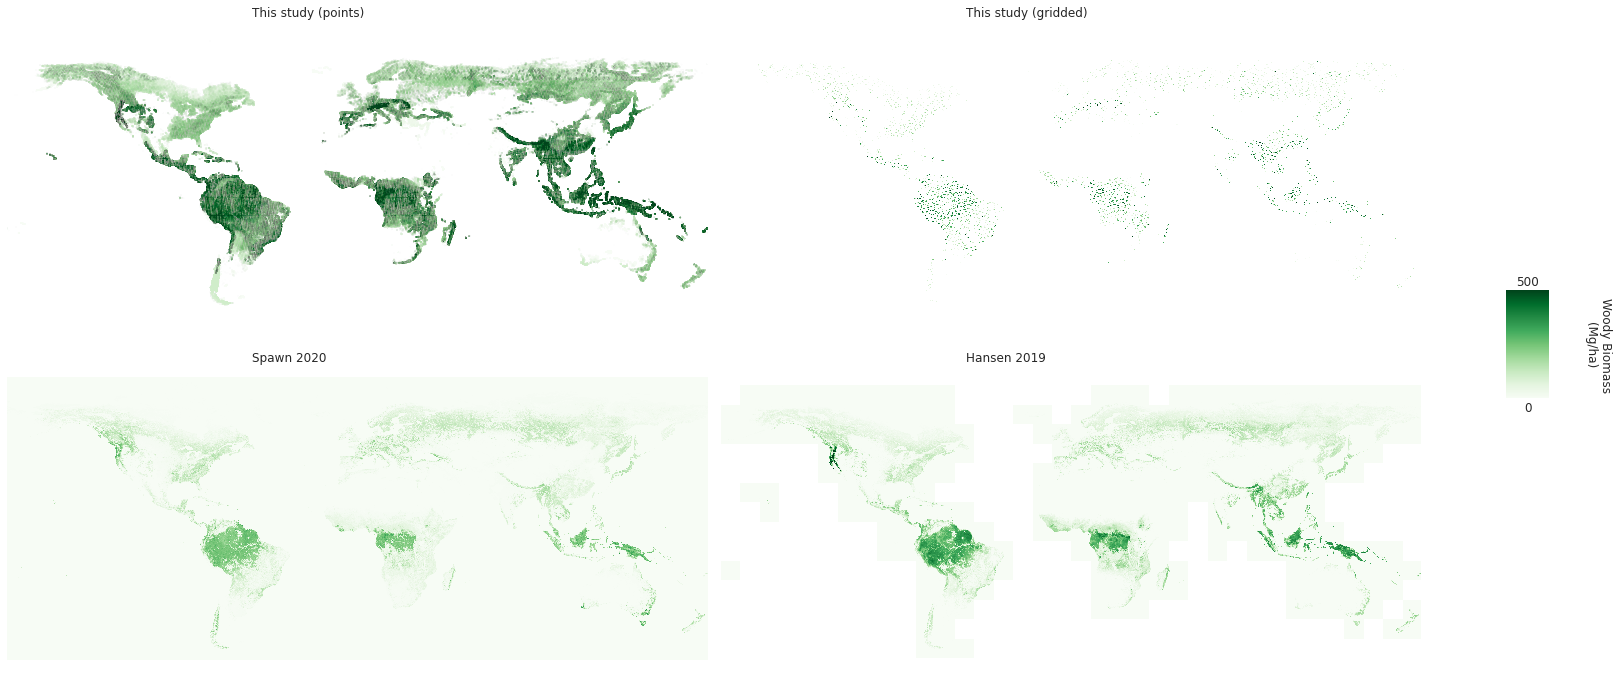

In [38]:
nrows = 2
ncols = 2
data_sets = [study, gridded_study_hansen, spawn, hansen]
titles = [
    "This study (points)",
    "This study (gridded)",
    "Spawn 2020",
    "Hansen 2019",
]

vmin, vmax = plot_params["var_lims"][0], plot_params["var_lims"][1]

plt.figure(figsize=(20, 10))
for i, d in enumerate(data_sets):
    plt.subplot(nrows, ncols, i + 1, projection=cartopy_proj_plate_carree())
    ax = plt.gca()

    if "lat" in d.coords:
        map_plot = d.biomass.plot.imshow(
            ax=ax,
            cmap=plot_params["cmap"],
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False,
            transform=ccrs.PlateCarree(),
        )
    else:
        # plot point cloud in scatter plots
        map_plot = d.plot.scatter(
            x="lon",
            y="lat",
            hue="biomass",
            hue_style="continuous",
            s=0.00005,
            ax=ax,
            cmap=plot_params["cmap"],
            vmin=vmin,
            vmax=vmax,
            add_guide=False,
            transform=ccrs.PlateCarree(),
        )

    map_pretty(
        ax,
        title=titles[i],
        min_lat=min_lat - 5,
        max_lat=max_lat + 5,
        min_lon=min_lon - 5,
        max_lon=max_lon + 5,
    )

fig = plt.gcf()
cax = fig.add_axes([1.05, 0.43, 0.03, 0.15])
cbar = fig.colorbar(map_plot, cax=cax, orientation="vertical")
cax.text(
    0.5,
    -0.12,
    plot_params["var_lims"][0],
    transform=cax.transAxes,
    horizontalalignment="center",
)
cax.text(
    0.5,
    1.05,
    plot_params["var_lims"][1],
    transform=cax.transAxes,
    horizontalalignment="center",
)
cax.text(
    1.8,
    0.5,
    plot_params["label"],
    transform=cax.transAxes,
    verticalalignment="center",
    multialignment="center",
    rotation=-90,
)
cbar.outline.set_visible(False)
cbar.set_ticks([])
plt.tight_layout()
plt.show()
plt.close()

In [39]:
gridded_study_spawn["diff_spawn"] = gridded_study_spawn["biomass"] - spawn["biomass"]
gridded_study_hansen["diff_hansen"] = gridded_study_hansen["biomass"] - hansen["biomass"]

In [40]:
gridded_study_spawn["diff_spawn"].isnull().sum().values

array(66513504)

In [41]:
gridded_study_spawn["biomass"].isnull().sum().values

array(66513504)

In [42]:
gridded_study_hansen["diff_hansen"].isnull().sum().values

array(79375438)

In [43]:
gridded_study_hansen["biomass"].isnull().sum().values

array(79375438)

In [44]:
if "spatial_ref" in gridded_study_hansen:
    gridded_study_hansen = gridded_study_hansen.drop_vars("spatial_ref")
    gridded_study_spawn = gridded_study_spawn.drop_vars("spatial_ref")

In [45]:
plot_params = {
    "cmap": cm.RdBu,
    "var_lims": (-250, 250),
    "label": "Diff in Biomass\n(Mg/ha)",
}

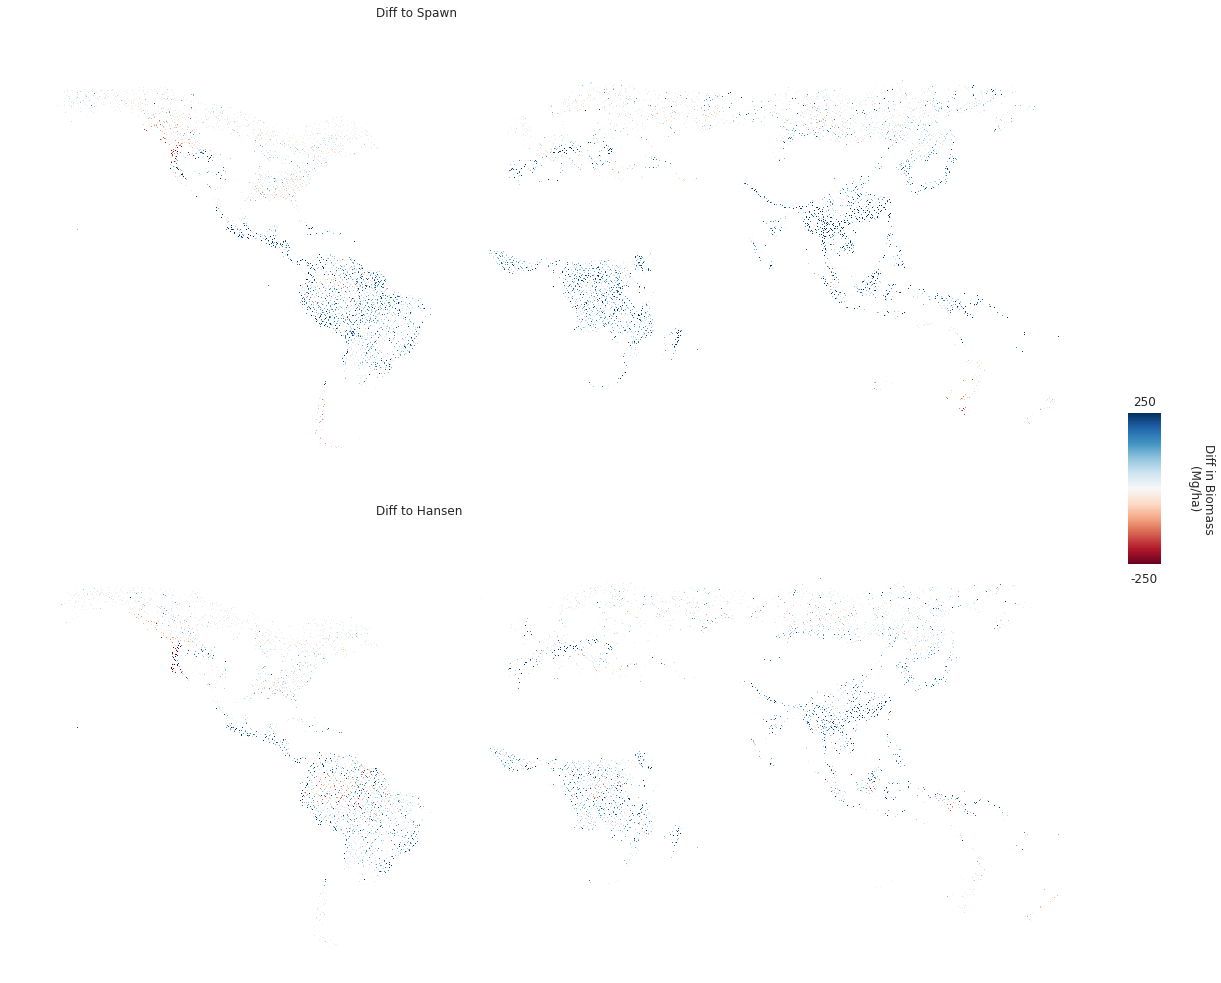

In [46]:
min_lat = gridded_study_hansen.lat.min()
max_lat = gridded_study_hansen.lat.max()
min_lon = gridded_study_hansen.lon.min()
max_lon = gridded_study_hansen.lon.max()

nrows = 2
ncols = 1
cols = ["diff_spawn", "diff_hansen"]
datasets = [gridded_study_spawn, gridded_study_hansen]
titles = ["Diff to Spawn", "Diff to Hansen"]

vmin, vmax = plot_params["var_lims"][0], plot_params["var_lims"][1]

plt.figure(figsize=(15, 14))
for i, (c, d) in enumerate(zip(cols, datasets)):
    plt.subplot(nrows, ncols, i + 1, projection=cartopy_proj_plate_carree())
    ax = plt.gca()

    map_plot = d[c].plot.imshow(
        ax=ax,
        cmap=plot_params["cmap"],
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        transform=ccrs.PlateCarree(),
    )

    map_pretty(
        ax,
        title=titles[i],
        min_lat=min_lat - 5,
        max_lat=max_lat + 5,
        min_lon=min_lon - 5,
        max_lon=max_lon + 5,
    )

fig = plt.gcf()
cax = fig.add_axes([1.05, 0.43, 0.03, 0.15])
cbar = fig.colorbar(map_plot, cax=cax, orientation="vertical")
cax.text(
    0.5,
    -0.12,
    plot_params["var_lims"][0],
    transform=cax.transAxes,
    horizontalalignment="center",
)
cax.text(
    0.5,
    1.05,
    plot_params["var_lims"][1],
    transform=cax.transAxes,
    horizontalalignment="center",
)
cax.text(
    1.8,
    0.5,
    plot_params["label"],
    transform=cax.transAxes,
    verticalalignment="center",
    multialignment="center",
    rotation=-90,
)
cbar.outline.set_visible(False)
cbar.set_ticks([])
plt.tight_layout()
plt.show()
plt.close()

In [47]:
gridded_study_spawn["mpe_spawn"] = 100.0 * gridded_study_spawn["diff_spawn"] / spawn["biomass"]
gridded_study_hansen["mpe_hansen"] = 100.0 * gridded_study_hansen["diff_hansen"] / hansen["biomass"]

# zarin = version 1 (baccini et al equation for tropics but using landsat)
# updated everything when producing global map (Harris et al) mostly using Baccini et al equation

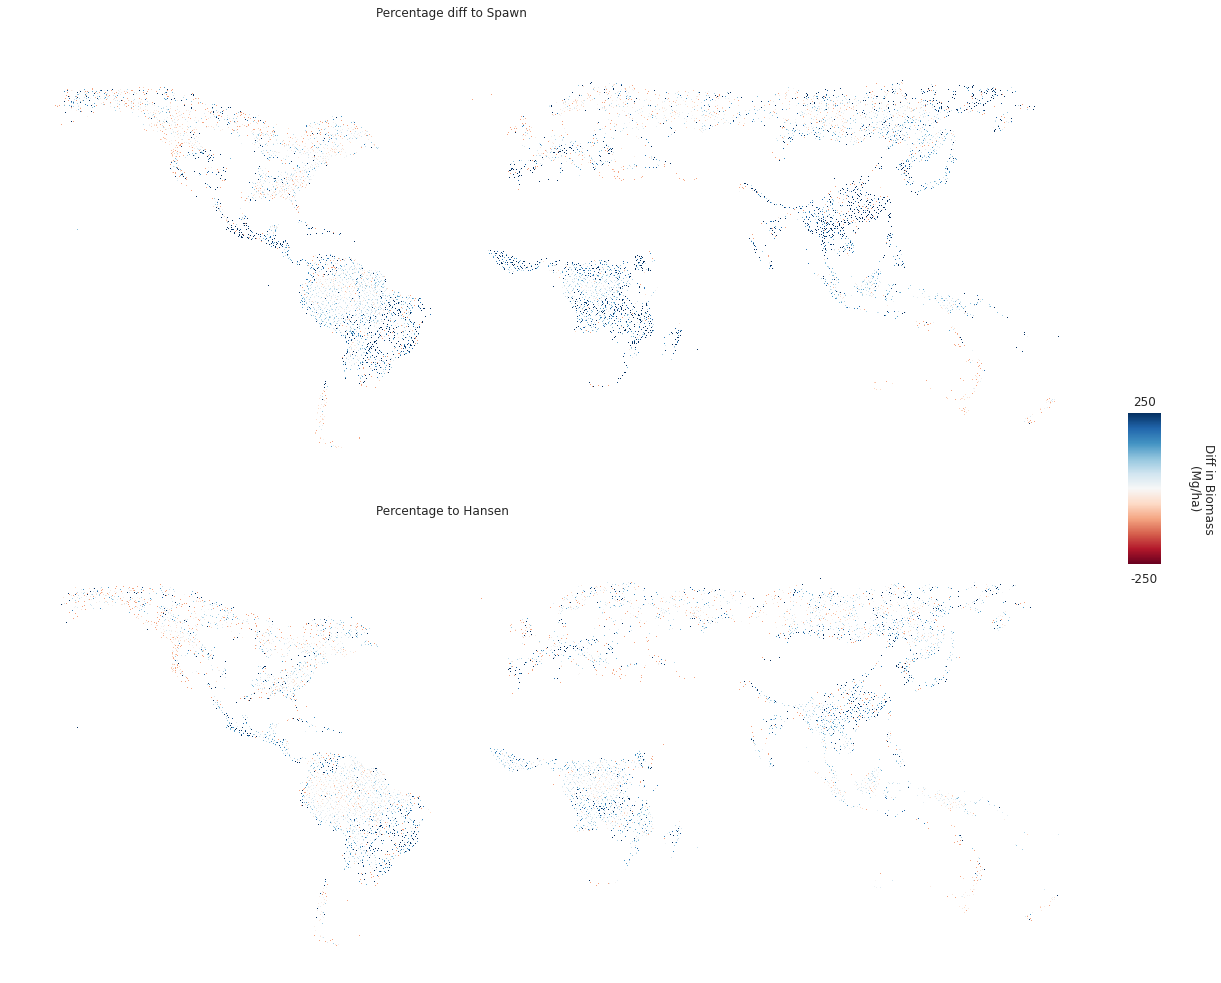

In [48]:
plot_params = {
    "cmap": cm.RdBu,
    "var_lims": (-250, 250),
    "label": "Diff in Biomass\n(Mg/ha)",
}

nrows = 2
ncols = 1
cols = ["mpe_spawn", "mpe_hansen"]
datasets = [gridded_study_spawn, gridded_study_hansen]
titles = ["Percentage diff to Spawn", "Percentage to Hansen"]

vmin, vmax = plot_params["var_lims"][0], plot_params["var_lims"][1]

plt.figure(figsize=(15, 14))
for i, (c, d) in enumerate(zip(cols, datasets)):
    plt.subplot(nrows, ncols, i + 1, projection=cartopy_proj_plate_carree())
    ax = plt.gca()

    map_plot = d[c].plot.imshow(
        ax=ax,
        cmap=plot_params["cmap"],
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        transform=ccrs.PlateCarree(),
    )

    map_pretty(
        ax,
        title=titles[i],
        min_lat=min_lat - 5,
        max_lat=max_lat + 5,
        min_lon=min_lon - 5,
        max_lon=max_lon + 5,
    )

fig = plt.gcf()
cax = fig.add_axes([1.05, 0.43, 0.03, 0.15])
cbar = fig.colorbar(map_plot, cax=cax, orientation="vertical")
cax.text(
    0.5,
    -0.12,
    plot_params["var_lims"][0],
    transform=cax.transAxes,
    horizontalalignment="center",
)
cax.text(
    0.5,
    1.05,
    plot_params["var_lims"][1],
    transform=cax.transAxes,
    horizontalalignment="center",
)
cax.text(
    1.8,
    0.5,
    plot_params["label"],
    transform=cax.transAxes,
    verticalalignment="center",
    multialignment="center",
    rotation=-90,
)
cbar.outline.set_visible(False)
cbar.set_ticks([])
plt.tight_layout()
plt.show()
plt.close()